In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [5]:
# 1d-Kalman Filter
# prior --> refers to state belief
# likelihood --> refers to belief in measurement

def update(prior, likelihood):
    # The Estimate is computed as multiplication between 
    #    1. belief (prior) 
    #    2. measurement (likelihood)
    # modeled as Gaussian Distribution 
    posterior = gaussian_multiply(likelihood, prior)
    return posterior

def gaussian_multiply(g1, g2):
    # Intuition: (filter is pulled towards distribution with lowest variance [ie highest confidence])
    mu1, var1 = g1
    mu2, var2 = g2
    # Kalman gain --> K = var(i)/var(i)+var(j)
    k1 = var2/(var1+var2)
    k2 = var1/(var1+var2)
    # NOTE: Is a point between measurement/prior (residual) based on variences(Kalman gain)
    mean = k2*mu2 + k1*mu1
    variance = (var1 * var2) / (var1 + var2)
    return (mean, variance) # Posterior

def predict(posterior, movement):
    x, P  = posterior # mean and variance of posterior
    dx, Q = movement  # mean and variance of movement
    x = x + dx
    P = P + Q
    return (x, P)

def kalman_Filter(belief, process_model, likelihood):
    # Predict
    prior = predict(belief, process_model)
    # Update --> [likelihood = (sensor_val, sensor_var)]
    belief = update(prior, likelihood)
    return belief,prior

In [6]:
## STEPS
# Initialization
#
#1. Initialize the state of the filter
#2. Initialize our belief in the state
#
# Predict
#
#1. Use system behavior to predict state at the next time step
#2. Adjust belief to account for the uncertainty in prediction
#
# Update
#
#1. Get a measurement and associated belief about its accuracy
#2. Compute residual between estimated state and measurement
#3. Compute scaling factor based on whether the measurementor prediction is more accurate
#4. set state between the prediction and measurement based on scaling factor
#5. update belief in the state based on how certain we are in the measurement


In [7]:
# Test 1D Kalman Filter on Synthetic Data
# Initialize process model & Initial position estimate 
n     = 200
frate = 10
dt    = np.cumsum(np.full((n,),1/frate))
velocity = 1  # m/s
pvar     = 40
mvar     = 40
noisevar = 10
# Simulate Data (Sensor Measurements and Actual Recordings) 
simulation   = np.zeros((n,))
measurements = np.zeros((n,))
festimates   = np.zeros((n,2))
predictions  = np.zeros((n,2))


prevval      = 0
for i,val in enumerate(simulation):
    model            = prevval + velocity * 1/frate
    sysnoise         = np.random.rand()*noisevar-np.random.rand()*noisevar
    recerr           = np.random.rand()*mvar-np.random.rand()*mvar
    simulation[i]    = model + sysnoise
    measurements[i]  = simulation[i] + recerr
    prevval          = simulation[i]

initpos     = (0,10**2)      # Norm dist (intial prediction of where the start is)
belief      = initpos
prevpos     = 0
print('Residuals:\tPrior\tKalman\tMeasurements')
for idx,pos in enumerate(measurements):
    likelihood  = (pos,mvar)
    # NOTE: this is a simple linear model, but it can be adaptive by basing it on trend of previous datapoints
    process_mod = (velocity*dt[idx]-prevpos,pvar) # Norm dist 
    belief,pred = kalman_Filter(belief, process_mod, likelihood)
    prevpos     = velocity*dt[idx]
    predictions[idx,:]  = pred
    festimates[idx,:]   = belief
    print(idx,"\t\t%.2f\t%.2f\t%.2f"%(abs(simulation[idx]-pred[0]),abs(simulation[idx]-belief[0]),abs(simulation[idx]-pos)))

Residuals:	Prior	Kalman	Measurements
0 		6.83	5.82	5.53
1 		2.98	15.81	26.38
2 		13.31	26.40	34.38
3 		21.51	9.58	2.22
4 		5.21	14.41	20.09
5 		20.31	7.05	1.15
6 		13.89	7.47	20.68
7 		5.38	10.52	13.70
8 		11.63	2.23	3.58
9 		4.95	9.98	13.10
10 		12.01	19.03	23.36
11 		20.48	3.90	18.97
12 		2.04	17.38	29.39
13 		20.17	26.20	29.92
14 		30.19	29.70	29.39
15 		32.62	0.24	20.55
16 		2.56	1.90	4.65
17 		5.30	16.03	22.66
18 		14.21	2.05	12.10
19 		1.92	5.03	9.32
20 		6.51	1.66	1.34
21 		7.28	1.34	2.33
22 		4.29	7.58	14.92
23 		1.34	1.59	3.39
24 		0.91	3.93	6.92
25 		1.78	3.78	5.02
26 		0.18	0.24	0.50
27 		1.05	2.53	3.44
28 		6.48	18.90	34.59
29 		21.07	2.96	8.23
30 		0.14	14.36	23.15
31 		8.22	11.05	12.81
32 		11.05	10.76	10.58
33 		17.56	23.51	27.19
34 		25.72	15.95	9.91
35 		11.07	6.00	2.87
36 		7.23	14.61	28.10
37 		20.36	13.77	9.69
38 		10.82	6.93	17.91
39 		9.45	0.48	5.06
40 		6.28	3.74	9.94
41 		9.49	10.99	11.92
42 		4.78	1.40	0.69
43 		0.57	8.98	14.89
44 		11.46	10.77	10.35
45 		10.44

Kalman Filter always makes a tradeoff between the prior belief and the measurement data


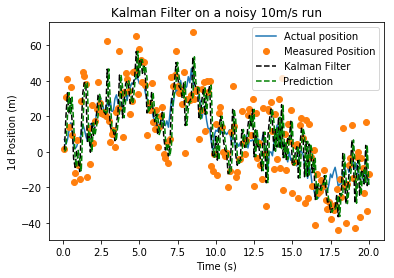

As more and more data is collected and predictions are made, the variance converges to a lower value


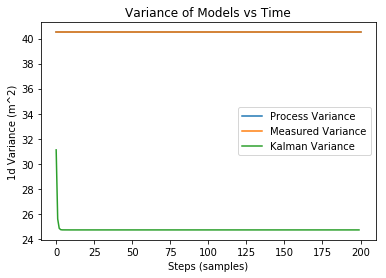

In [8]:
# Visualize 
# Filter accuracy
print("Kalman Filter always makes a tradeoff between the prior belief and the measurement data")
plt.plot(dt,simulation)
plt.plot(dt,measurements,'o')
plt.plot(dt,festimates[:,0],'k--')
plt.plot(dt,predictions[:,0],'g--')
plt.title('Kalman Filter on a noisy 10m/s run')
plt.xlabel('Time (s)')
plt.ylabel('1d Position (m)')
plt.legend(['Actual position','Measured Position','Kalman Filter','Prediction'])
plt.show()
# Varience
print("As more and more data is collected and predictions are made, the variance converges to a lower value")
plt.title('Variance of Models vs Time')
plt.xlabel('Steps (samples)')
plt.ylabel('1d Variance (m^2)')
plt.plot([0,n],[np.max(mvar)+0.5,np.max(mvar)+0.5])
plt.plot([0,n],[np.max(pvar)+0.5,np.max(pvar)+0.5])
plt.plot(festimates[:,1])
plt.legend(['Process Variance','Measured Variance','Kalman Variance'])
plt.show()